# 数値解析第７回課題

### 学籍番号：08B22182　氏名：平山聖輝

課題7

次式に示す２変数の $ (x,y) $ の非線形連立方程式をニュートン・ラフソン法で解くことを考える．

$$
\left\{
\begin{align}
(x - 9)^2 + (y - 5)^2 &= 64 \\
(x + 2)^2 + (y + 1)^2 &= 36
\end{align}
\right.
$$

* 適切に $ f_1(x,y) = 0 $ および $ f_2(x,y) = 0 $ を決め， $ \boldsymbol{f} = ( f_1(x,y), f_2(x,y) )^T $ とする． $ \boldsymbol{f} $ に対するヤコビアン $ \boldsymbol{D}\boldsymbol{f}(x,y) $ を求めよ．
*  $ (x^{(1)}, y^{(1)}) = (1,1) $ から $ (x^{(2)}, y^{(2)} ) $ を求めよ．

### プログラミングの初期設定

In [145]:
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact
from sympy import *

まずはSympyによる数式処理を実行する．

In [97]:
x = Symbol('x')
y = Symbol('y')
h1 = Symbol('h1')
h2 = Symbol('h2')
h = Matrix([[h1],[h2]])

初期値と繰り返し回数，計算終了時の誤差を設定する．

In [254]:
x_init = Matrix([ [1], [1] ])
times = 1000
e = 10e-6

### 二変数のニュートン・ラフソン法について

一変数のニュートン・ラフソン法と同様に更新則はベクトル
$ \boldsymbol{h} = \left[
\begin{array}{c}
h_1 \\ h_2 
\end{array}\right]
$
とベクトル
$ \boldsymbol{x} = \left[
\begin{array}{c}
x \\ y
\end{array}
\right]
$
を用いて

$$
\boldsymbol{x}^{(k+1)} = \boldsymbol{x}^{(k)} + \boldsymbol{h}^{(k)}
$$

により更新していけばよい．ここで一変数のときの $ h $ が

$$
h^{(k)} = -\frac{f'(x^{(k)})}{f(x^{(k)})}
$$

であったため，二変数のときはベクトル
$ \boldsymbol{x} = (x, y)^T, \boldsymbol{f} = (f_1(\boldsymbol{x}),f_2(\boldsymbol{x}))^T $ に関するヤコビアン $ \boldsymbol{D}\boldsymbol{f}(\boldsymbol{x}^{(k)}) $ をもちいて $ \boldsymbol{h} $ を求めればよい．ここでヤコビアン $\boldsymbol{D}\boldsymbol{f}(\boldsymbol{x}^{(k)})$ とは

$$
\boldsymbol{D} = \left[
\begin{array}{cc}
\frac{\partial{f_1}}{\partial{x}} & \frac{\partial{f_1}}{\partial{y}} \\
\frac{\partial{f_2}}{\partial{x}} & \frac{\partial{f_2}}{\partial{y}}
\end{array}
\right]_{\boldsymbol{x} = \boldsymbol{x}^{(k)}}
$$


を満たすものである．よって $ \boldsymbol{h}^{(k)} $ は

$$
\boldsymbol{f}(\boldsymbol{x}^{(k)}) + \boldsymbol{D}\boldsymbol{f}(\boldsymbol{x}^{(k)})\boldsymbol{h}^{(k)} = \boldsymbol{0}
$$

を満たすように設定すればよい．ここでヤコビアンの逆行列を求めるのは計算コストがかかるためLU分解などで工夫して計算する必要があるのは第４回課題でも解いたとおりである．

### 解くべき方程式とヤコビアンの設定

In [101]:
f1 = (x - 9)**2 + (y - 5)**2 - 64
f2 = (x + 2)**2 + (y + 1)**2 - 36
F = Matrix([[f1],[f2]])
display(F)

Matrix([
[(x - 9)**2 + (y - 5)**2 - 64],
[(x + 2)**2 + (y + 1)**2 - 36]])

よってヤコビアンは以下

In [103]:
X = Matrix([[x], [y]])
J = F.jacobian(X)
#なんとF.jacobianでヤコビアンを計算してくれる！sympyの恩恵！
display(J)

Matrix([
[2*x - 18, 2*y - 10],
[ 2*x + 4,  2*y + 2]])

### 二回目の値$\boldsymbol{x}^{(2)}$を求める

solve関数を用いて解いてもいいが，せっかくなので第四回のLU分解のコードを使って計算する．

In [135]:
def LU_division(mat_A):
    num_vec_x = mat_A.shape[0] #行数の取得
    mat_L = np.eye(num_vec_x) #L=Aと同じn×nの単位行列
    mat_U = mat_A.copy() #はじめはU=A
    mat_LU = np.concatenate((mat_L, mat_U), axis = 1)
    print(mat_LU, "\n↓")
    

    #A=LUのLU分解を行う
    for pivot in range(num_vec_x):
        temp_U = mat_U.copy() #mat_Uの情報をいじっちゃわないように逃げのtemp_Uを用意
        val = temp_U[pivot, pivot]
        #ピボットの確認
        print("pivot =", val)

        for row in range(pivot+1, num_vec_x):
            #pivot以降の行からpivot行をmat_U[row,pivot]/val倍して引く->U
            pivot_row = (mat_U[row, pivot] / val) * mat_U[pivot, range(pivot, num_vec_x)]
            mat_U[row, range(pivot, num_vec_x)] -= pivot_row
            
            #L[row, pivot]にmat_U[row,pivot]/valを代入
            mat_L[row, pivot] = temp_U[row, pivot] / val

            #LUを表示
            mat_LU = np.concatenate((mat_L, mat_U), axis = 1)
            print(mat_LU, "\n↓")
            
    return mat_L, mat_U

In [107]:
def forward_elimination(mat_L, vec_b):
    #Ly=bの前進消去を行う
    vec_y = np.zeros(vec_b.shape) #yを1×nの行列に
    num_vec_x = mat_L.shape[0]

    for row in range(0,num_vec_x): #前進0～n-1
        y_temp = vec_b[row, 0] #内積の計算をするために逃げの変数用意
        for column in range(0, row, 1):
            y_temp = y_temp - mat_L[row, column]*vec_y[column, 0] #columnとcolumnで縮約！
        vec_y[row, 0] = y_temp / mat_L[row, row] #最後y[row, 0]の係数L[row, row]で割る
        print("y=", vec_y, "\n↓")
        
    return vec_y

In [109]:
def back_substitution(mat_U, vec_y):
    #Ux=yの後退代入を行う
    vec_x = np.zeros(vec_y.shape)
    num_vec_x = mat_U.shape[0]

    for row in range(num_vec_x-1, -1, -1): #後退n-1~0
        x_temp = vec_y[row] #前進消去と考え方は同じ,forの向きが変わるだけ
        for column in range(num_vec_x-1, row, -1):
            x_temp = x_temp - mat_U[row, column]*vec_x[column,0]
        vec_x[row] = x_temp / mat_U[row, row]
        print("x=", vec_x, "\n↓")
    
    return vec_x

In [221]:
mat_J = J.subs([(x, x_init[0,0]),(y, x_init[1,0])]) #Jにx_initを代入する
mat_F = F.subs([(x, x_init[0,0]),(y, x_init[1,0])])
array_J = matrix2numpy(mat_J) #matrix2numpyでnumpyでつかえるarray型に直す．
array_F = matrix2numpy(mat_F)
mat_L, mat_U = LU_division(array_J)
vec_y = forward_elimination(mat_L, -array_F) #Df(x)h = -F(x)
h_ans1 = back_substitution(mat_U, vec_y)
h_ans1

[[1.0 0.0 -16 -8]
 [0.0 1.0 6 4]] 
↓
pivot = -16
[[1.0 0.0 -16 -8]
 [-0.375 1.0 0 1]] 
↓
pivot = 1
y= [[-16.]
 [  0.]] 
↓
y= [[-16.]
 [ 17.]] 
↓
x= [[ 0.]
 [17.]] 
↓
x= [[-7.5]
 [17. ]] 
↓


array([[-7.5],
       [17. ]])

In [213]:
ans = solve(J.subs([(x, x_init[0,0]),(y, x_init[1,0])]) * h + F.subs([(x, x_init[0,0]),(y, x_init[1,0])]))
ans

{h1: -7.50000000000000, h2: 17.0000000000000}

したがって求めるべき$\boldsymbol{x}^{(2)}$ は

$$
\begin{align}
\boldsymbol{x}^{(2)} &= \boldsymbol{x}^{(1)} + \boldsymbol{h}^{(1)} \\
&= \left[\begin{array}{c} 1 \\ 1 \end{array}\right] + \left[\begin{array}{c} -7.5 \\ 17 \end{array}\right] \\
&= \left[\begin{array}{c} -6.5 \\ 18 \end{array}\right]
\end{align}
$$

となることが分かった．

### 繰り返し計算により解を得る

In [294]:
def multiNewton(x_init, n):
    x_b = x_init
    x_ans = matrix2numpy(x_b) #mat_Jのとき同様numpyでつかえるように型を変える
    deltas = [] #残差delta
    deltas.append(0)
    count = 0

    for n in range(n):
    
        ## f(x) + J(x) h = 0 を解く
        ans = solve(J.subs([(x, x_b[0,0]), (y, x_b[1,0])]) * h+F.subs([(x, x_b[0,0]), (y, x_b[1,0])]))
        h_ans = Matrix([[ans[h1]], [ans[h2]]])
    
        ## xの更新
        x_a  = x_b + h_ans
    
        x_ans = np.c_[x_ans, matrix2numpy(x_a)]
        deltas = np.c_[deltas, (x_a- x_b).norm().evalf()]
        count = count + 1;
        print('count=', count, '\n')
        if (x_a - x_b).norm()< e : break
        x_b = x_a
        
    return x_ans, deltas

In [296]:
x_ans, delta = multiNewton(x_init, times)
print(x_ans[0,-1].evalf()) #リストの番号でマイナス(－)は後ろから何番目か
print(x_ans[1,-1].evalf()) #evalfは解を近似している．

count= 1 

count= 2 

count= 3 

count= 4 

count= 5 

count= 6 

count= 7 

count= 8 

1.04306320119422
4.17105079781059


繰り返し中の結果をグラフにて表示すると以下のようになる．

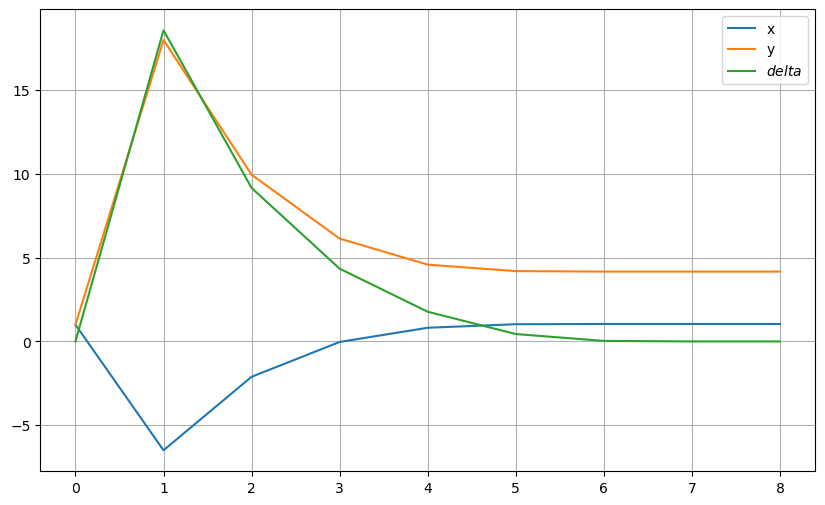

In [266]:
fig = plt.figure(figsize=(10, 6.0))
plt.plot(x_ans[0,:],label="x")
plt.plot(x_ans[1,:],label="y")
plt.plot(delta[0,:], label='$delta$')
plt.legend(loc='upper right',)
plt.grid() 
plt.show()

したがってこの結果からこの二変数非線形連立方程式の解は

$$
\boldsymbol{x} = \left[
\begin{array}{c}
1.04306320119422 \\
4.17105079781059
\end{array}
\right]
$$

だと求めることができた．また誤差が $ 10^{-6} $ 以下になるための繰り返し回数は$8$回であったこともわかった．